# Notes

### To do
* readings, try to regress for widths and normalizations, then reprocess all data, then empircally test different hyperparameter combinations for the models.

### To read
* [sklearn regressor chain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.RegressorChain.html)
* [sklearn svms](https://scikit-learn.org/stable/modules/svm.html)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, median_absolute_error
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
#plt.rcParams['figure.dpi']=150

data_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=AQN5JTYUIYYWNOZEPNSU42LBZT3E2')

In [3]:
# Split data into qpo present and qpo absent 

no_qpo_idx = np.where(data_df['first_par1s']==0)[0]
has_qpo_idx = np.where(data_df['first_par1s']!=0)[0]

has_qpo_df = data_df.iloc[has_qpo_idx, :].sample(frac=1)
no_qpo_df = data_df.iloc[no_qpo_idx, :].sample(frac=1)

print(len(has_qpo_df.index))

57


In [4]:
# prepare data for analysis

# QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(has_qpo_df['num_qpos']).reshape(len(has_qpo_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

# NO QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo) = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals_no_qpo = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals_no_qpo = np.vstack([x_vals_no_qpo, new_arr])

# num QPOS
num_qpos_no_qpo = np.array(no_qpo_df['num_qpos']).reshape(len(no_qpo_df), 1).astype(int)

# Y 
y_vals_no_qpo = np.array([], dtype=np.float32).reshape(0, 3)

freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals_no_qpo = np.vstack([y_vals_no_qpo, new_arr])

In [5]:
# General functions

def split_data(x_vals, y_vals, num_qpos): 
    # Train test split
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test, qpo_train, qpo_test

def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def drop_no_qpo(X_test, y_test, knn_qpo_predictions): 
    non_zero_indices = np.where(knn_qpo_predictions!=0)
    return X_test[non_zero_indices], y_test[non_zero_indices]

In [27]:
# train test splitting and combining

X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
X_train_no_qpo, X_test_no_qpo, y_train_no_qpo, y_test_no_qpo, qpo_train_no_qpo, qpo_test_no_qpo = split_data(x_vals_no_qpo, y_vals_no_qpo, num_qpos_no_qpo) 

X_train_combined = np.concatenate((X_train, X_train_no_qpo))
X_test_combined = np.concatenate((X_test, X_test_no_qpo))
qpo_train_combined = np.concatenate((qpo_train, qpo_train_no_qpo))
qpo_test_combined = np.concatenate((qpo_test, qpo_test_no_qpo))

y_test_combined = np.concatenate((y_test, y_test_no_qpo))

In [28]:
knn_acc, knn_predictions = knn_predict(7, X_train_combined, qpo_train_combined, X_test_combined, qpo_test_combined)

knn_predictions = knn_predictions.flatten().astype(int)
knn_predictions

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([2, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0])

In [29]:
model = LinearSVR()

wrapper = RegressorChain(model, order=[0,1,2])

wrapper.fit(X_train,y_train)

x_test_no_qpo_predicted, y_test_no_qpo_predicted = drop_no_qpo(X_test_combined, y_test_combined, knn_predictions)

chained_predictions = cullBuffers(wrapper.predict(x_test_no_qpo_predicted), knn_predictions).flatten()

mse = mean_squared_error(y_test_no_qpo_predicted.flatten(), chained_predictions)
mae = median_absolute_error(y_test_no_qpo_predicted.flatten(), chained_predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


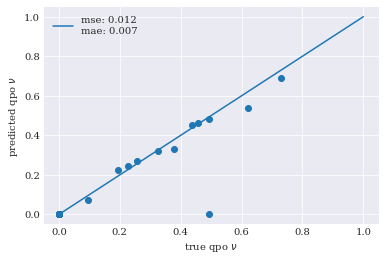

In [30]:
fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_no_qpo_predicted.flatten(), chained_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

### Check with simple linear

In [31]:
model = LinearRegression()

wrapper = RegressorChain(model, order=[0,1,2])

wrapper.fit(X_train,y_train)

x_test_no_qpo_predicted, y_test_no_qpo_predicted = drop_no_qpo(X_test_combined, y_test_combined, knn_predictions)

chained_predictions = cullBuffers(wrapper.predict(x_test_no_qpo_predicted), knn_predictions).flatten()

mse = mean_squared_error(y_test_no_qpo_predicted.flatten(), chained_predictions)
mae = median_absolute_error(y_test_no_qpo_predicted.flatten(), chained_predictions)

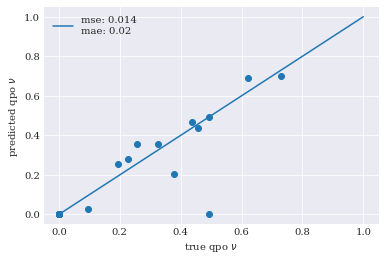

In [32]:
fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_no_qpo_predicted.flatten(), chained_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

### KNN decision boundaries plot

In [68]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import seaborn as sns

paired_colors = np.array(sns.color_palette("Paired"))


IndexError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


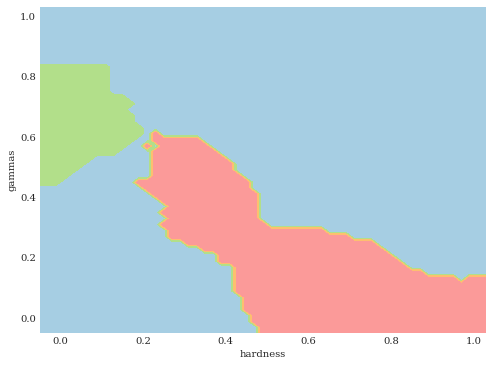

In [91]:
x1 = X_train_combined[:,0] #  0 and 3 for hardness and gammas
x2 = X_train_combined[:,3] 


X = np.array([], dtype=np.float).reshape(0,2) 

for a, b, in zip(x1,x2): 
    new_arr = np.array([float(a), float(b)])
    X = np.vstack([X, new_arr])

h = 0.02

cmap_light = ListedColormap(paired_colors[[0,2,6,4]])
cmap_bold = paired_colors[[1,3,7,5]]

zero_mask = np.where(qpo_train_combined==0)
one_mask = np.where(qpo_train_combined==1)
two_mask = np.where(qpo_train_combined==2)
three_mask = np.where(qpo_train_combined==3)

colors_arr = []

for val in qpo_train_combined: 
    if val == 0: 
        colors_arr.append(cmap_bold[0])
    elif val == 1: 
        colors_arr.append(cmap_bold[1])
    elif val == 2: 
        colors_arr.append(cmap_bold[2])
    elif val == 3: 
        colors_arr.append(cmap_bold[3])

knn = KNeighborsClassifier(7)
knn.fit(X, qpo_train_combined)

x_min, x_max = x1.min() - 0.05, x1.max() + 0.05
y_min, y_max = x2.min() - 0.05, x2.max() + 0.05

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

# Actual plot
fig, ax = plt.subplots(figsize=(8, 6))

plt.contourf(xx, yy, Z, cmap=cmap_light)

#plt.scatter(x1, x2, c=colors_arr)

ax.set(xlabel=arr_names[0], ylabel=arr_names[3])

#plt.legend()

plt.show()